In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Plot2d
from data_analysis_codes.tools import Cstyle
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as GVar
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
plt.style.use(Cstyle.style1)

In [2]:
param = RRead.read_parameters('pflrw_A0_L1821_t1_N128_LCDM')
Lin = LinData.LinData_Class(param)
FD = FD_file.FD_Class(param['dx'], order6 = True)
RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
get_var = GVar.Get_var(param, Lin)

 read time file


In [3]:
path = param['h5datapath']+param['simname']
it = 50000
f = h5py.File('{}_it_{:06d}.hdf5'.format(path, it), 'r')
Kdict = get_var.get_the_curv(f, it)
gdown = Kdict['metric_dic']['gdown']
gup = Kdict['metric_dic']['gup']
Gudd = RCW.Christoffel_symbol(gdown, gup)
Kdown = Kdict['Kdown']
K = Kdict['K']

In [4]:
gxx = gdown[0,0]
gxy = gdown[0,1]
gxz = gdown[0,2]
gyy = gdown[1,1]
gyz = gdown[1,2]
gzz = gdown[2,2]

phi = np.sign(Lin.d3y) * np.arccos(Lin.d3x / np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y))
phi[np.logical_and(np.sign(Lin.d3y) == 0.0, np.sign(Lin.d3x)<0)] = np.pi
phi[np.where(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y == 0)] = 0

r = np.sqrt(Lin.d3x*Lin.d3x + Lin.d3y*Lin.d3y + Lin.d3z*Lin.d3z)
theta = np.arccos(Lin.d3z / r)
theta[np.where(r == 0)] = 0

xynorm = (np.cos(phi)**2 * gxx 
          + 2 * np.cos(phi) * np.sin(phi) * gxy 
          + np.sin(phi)**2 * gyy)

xyznorm = (np.sin(theta)**2 * xynorm 
           + 2 * np.cos(theta) * np.sin(theta) * (np.cos(phi) * gxz + np.sin(phi) * gyz)
           + np.cos(theta)**2 * gzz)

Sx = np.cos(phi) * np.sin(theta) / np.sqrt(xyznorm)
Sy = np.sin(phi) * np.sin(theta) / np.sqrt(xyznorm)
Sz = np.cos(theta) / np.sqrt(xyznorm)

sup = np.array([Sx, Sy, Sz])

/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [5]:
norm = np.einsum('i..., j..., ij... -> ...', sup, sup, gdown)
np.max(norm), np.median(norm), np.min(norm)

(1.0000000000000007, 1.0, 0.9999999999999993)

# Check $s^i$

In [6]:
t = Lin.temp_from_temp('t', 'it', it)
print(np.average(gxx), np.average(gyy), np.average(gzz), Lin.evo.a(t)**2)
print(np.average(gxy), np.average(gxz), np.average(gyz))

0.03509755594243498 0.03509755594243498 0.03509755594243498 0.0350975559847465
0.0 0.0 0.0


In [7]:
t = Lin.temp_from_temp('t', 'it', it)
sup_an = np.array([Lin.d3x, Lin.d3y, Lin.d3z]) / (Lin.evo.a(t) * r)
norm = np.einsum('i..., j..., ij... -> ...', sup_an, sup_an, gdown)
print(np.nanmax(norm), np.nanmedian(norm), np.nanmin(norm))

print(np.average(sup), np.nanmean(sup_an))

0.9999999987944644 0.9999999987944638 0.9999999987944632
-0.0330829207529351 -0.033083784927596664


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


# Check 1st term

0.013917648128163294
inf


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'Rel diff')

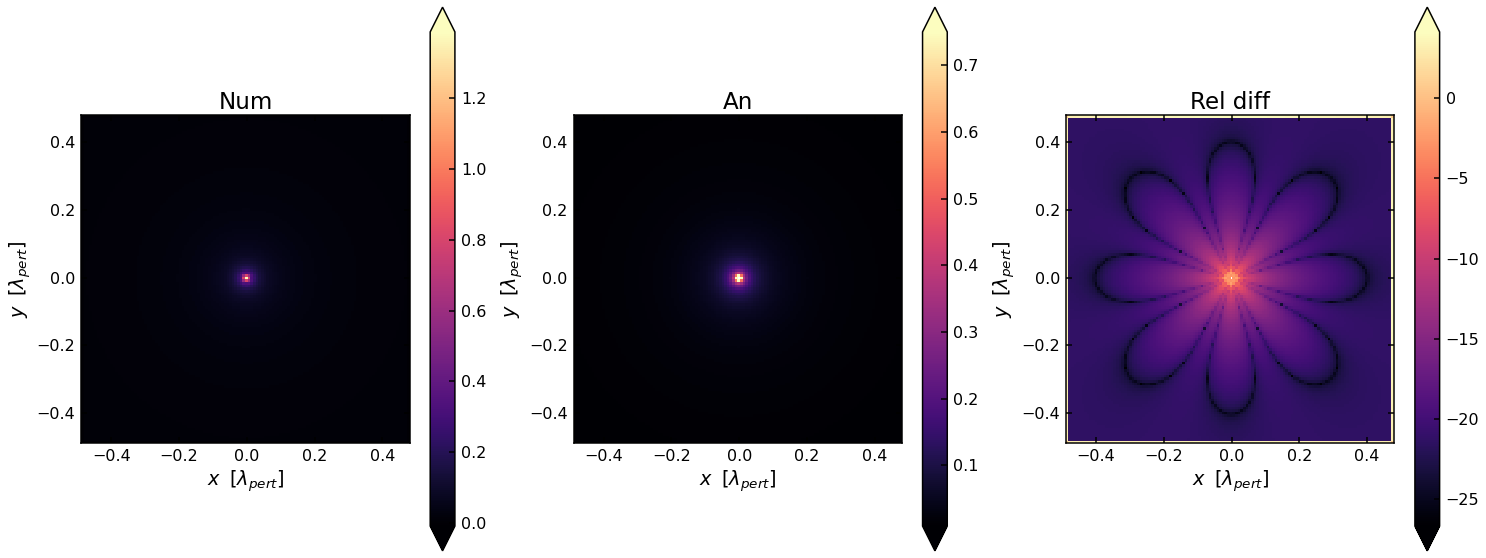

In [11]:
icut = 2

disi = np.einsum('aa... -> ...', RCW.CovD3_tensor1up(Gudd, sup))
print(np.average(disi[icut:-icut, icut:-icut, icut:-icut]))

disi_an = 2/(Lin.evo.a(t)*r)
print(np.average(disi_an))

plt.figure(figsize=(25, 10))
coorcoor = Lin.d3xyz[icut:-icut]/param['Lx']

plt.subplot(131)
data1 = disi[icut:-icut, icut:-icut, int(param['Nx']/2)].T
plt.pcolormesh(coorcoor, coorcoor, data1, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title('Num')

plt.subplot(132)
data2 = disi_an[icut:-icut, icut:-icut, int(param['Nx']/2)].T
plt.pcolormesh(coorcoor, coorcoor, data2, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title('An')

plt.subplot(133)
data = np.log(abs((data1-data2)/data1))
plt.pcolormesh(coorcoor, coorcoor, data, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title('Rel diff')

# Check 2nd term

In [13]:
Kss = np.einsum('ij..., i..., j... -> ...', Kdown, sup, sup)
Kss_an = -Lin.evo.Hprop(t)
np.average(Kss), np.average(Kss_an)

(-0.0015657676129250358, -0.0015657676138587805)

# Check 3rd term

In [14]:
np.average(K), -3*Lin.evo.Hprop(t)

(-0.004697302838775102, -0.004697302841576341)

# Check $\Theta$

0.017049183354013363
inf


/opt/apps/pkgs/jupyterhub/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'Rel diff')

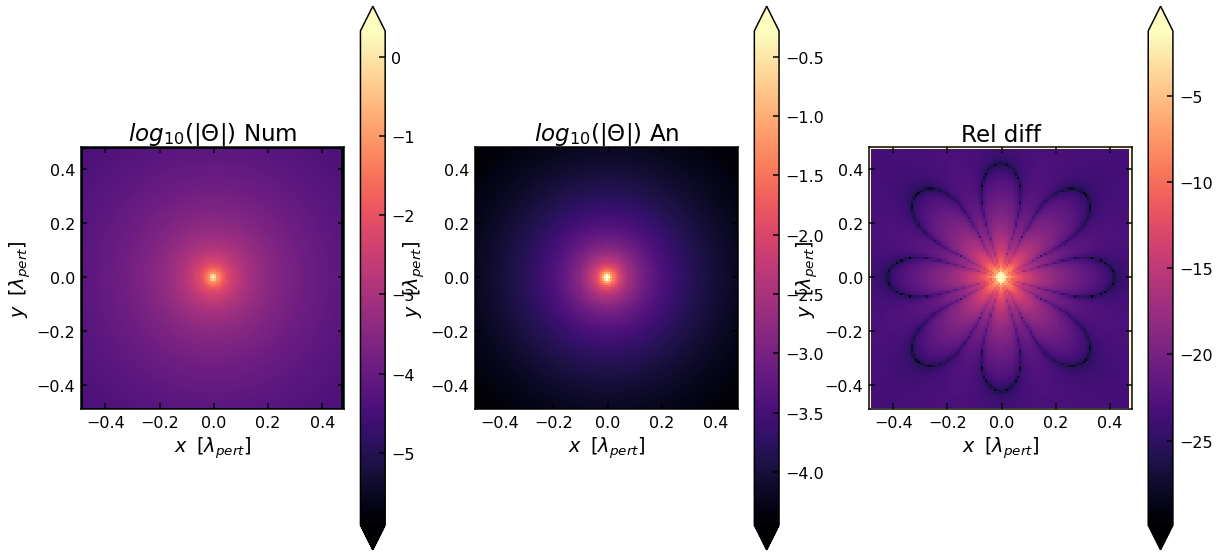

In [16]:
Theta = (np.einsum('aa... -> ...', RCW.CovD3_tensor1up(Gudd, sup)) 
         + np.einsum('ij..., i..., j... -> ...', Kdown, sup, sup) 
         - K)
print(np.average(Theta[icut:-icut, icut:-icut, icut:-icut]))

Theta_an = (2/(Lin.evo.a(t)*r)
           + (-Lin.evo.Hprop(t))
           - (-3*Lin.evo.Hprop(t)))
print(np.average(Theta_an[icut:-icut, icut:-icut, icut:-icut]))

plt.figure(figsize=(20, 10))
coorcoor = Lin.d3xyz[icut:-icut]/param['Lx']

plt.subplot(131)
data1 = np.log(abs(Theta[icut:-icut, icut:-icut, int(param['Nx']/2)].T))
plt.pcolormesh(coorcoor, coorcoor, data1, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$log_{10}(|\Theta|)$ Num')

plt.subplot(132)
data2 = np.log(abs(Theta_an[icut:-icut, icut:-icut, int(param['Nx']/2)].T))
plt.pcolormesh(coorcoor, coorcoor, data2, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$log_{10}(|\Theta|)$ An')

plt.subplot(133)
data = np.log(abs((data1-data2)/data1))
plt.pcolormesh(coorcoor, coorcoor, data, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title('Rel diff')

Text(0.5, 1.0, '$log_{10}(|\\Theta|)$')

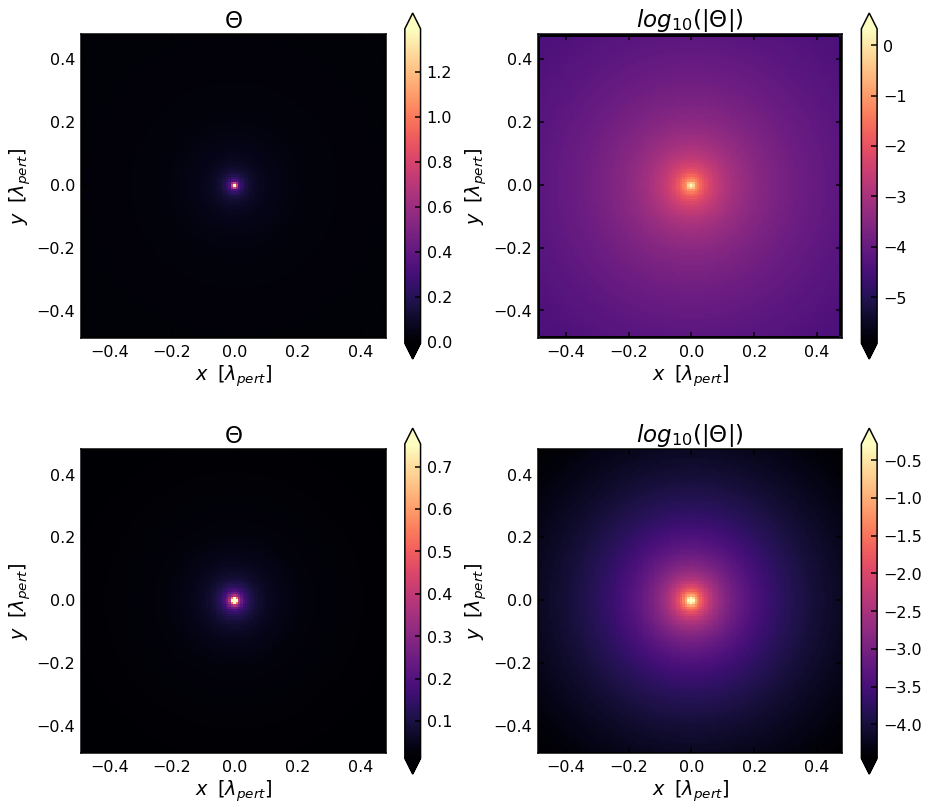

In [25]:
plt.figure(figsize=(15, 14))
coorcoor = Lin.d3xyz[icut:-icut]/param['Lx']

plt.subplot(221)
data1 = Theta[icut:-icut, icut:-icut, int(param['Nx']/2)].T
plt.pcolormesh(coorcoor, coorcoor, data1, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$\Theta$')

plt.subplot(222)
data2 = np.log(abs(Theta[icut:-icut, icut:-icut, int(param['Nx']/2)].T))
plt.pcolormesh(coorcoor, coorcoor, data2, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$log_{10}(|\Theta|)$')

plt.subplot(223)
data1 = Theta_an[icut:-icut, icut:-icut, int(param['Nx']/2)].T
plt.pcolormesh(coorcoor, coorcoor, data1, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$\Theta$')

plt.subplot(224)
data2 = np.log(abs(Theta_an[icut:-icut, icut:-icut, int(param['Nx']/2)].T))
plt.pcolormesh(coorcoor, coorcoor, data2, shading='nearest')
plt.gca().set_aspect("equal")
plt.colorbar(extend='both')
plt.xlabel(r'$x\;\;[\lambda_{pert}]$')
plt.ylabel(r'$y\;\;[\lambda_{pert}]$')
plt.title(r'$log_{10}(|\Theta|)$')